# 整合`Alphalens`及`Pyfolio`

`Alphalens`可以模拟投资组合的表现，其中的因子值用于权重。投资组合一旦建成，可以通过`Pyfolio`进行分析。有关如何构建此组合的详细信息，请参阅：
- alphalens.performance.factor_returns
- alphalens.performance.cumulative_returns 
- alphalens.performance.create_pyfolio_input

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%pylab inline --no-import-all
import alphalens
import pyfolio
import pandas as pd
import numpy as np
import datetime

Populating the interactive namespace from numpy and matplotlib


加载股价数据

In [3]:
pan = pd.read_pickle('prices.pkl').to_frame()

我们将计算一个简单的均值回归因子来考察近期股票表现：在过去5天表现良好的股票将有较高的排名，反之亦然。

In [4]:
factor = - pan.groupby(level=1)['open'].pct_change(5)
factor.index.names = ['date', 'asset']
#factor = factor.unstack(1).iloc[5:]

In [5]:
# 注意因子数据格式
factor.tail()

date                       asset       
2018-05-17 00:00:00+00:00  华友钴业(603799)   -0.151256
                           鼎胜新材(603876)   -0.078813
                           长城科技(603897)   -0.047953
                           兆易创新(603986)    0.010817
                           洛阳钼业(603993)   -0.074219
Name: open, dtype: float64

传递给alphalens的股价数据应包含资产的入场价格，因此它必须反映在给定时间戳处观察到因素值后的下一个可用价格。这些价格不能用于计算当时的因子值。 一定要仔细检查，以确保你不会在研究中引入`超前偏差`。

股价数据还必须包含资产的退出价格，期间1将使用下一个时间戳的价格，期间2将使用2个时间戳后的价格，以此类推。

因子的计算在时间频率上没有任何限定和假设，开盘交易，收盘交易及日内交易均可。只要求因子和股价`DataFrames`根据上面的规则正确对齐。

在我们的例子中，在每天交易开始之前，我们观察到昨天的因子值。我们传递给`alphalens`的价格是该观测因子下一个可用价格：每日开盘价将用作资产入场价格。 另外，我们并没有增加额外价格数据，所以资产的退出价格将是以后几天的开盘价（多少天取决于`periods`参数）。`Alphalens`计算的收益率因此将基于资产开盘价。

In [6]:
pricing = pan['close'].unstack(1).iloc[1:]
pricing.head()

asset,平安银行(000001),万 科Ａ(000002),沙河股份(000014),深科技(000021),深天马Ａ(000050),中国长城(000066),华侨城Ａ(000069),中成股份(000151),美的集团(000333),潍柴动力(000338),...,南威软件(603636),畅联股份(603648),七一二(603712),仙鹤股份(603733),沃格光电(603773),华友钴业(603799),鼎胜新材(603876),长城科技(603897),兆易创新(603986),洛阳钼业(603993)
date,,,,,,,,,,,,,,,,,,,,,
2017-12-18 00:00:00+00:00,12.75,28.46,12.20,9.58,19.913,6.94,8.13,12.65,54.072,7.750,...,10.802,19.85,NaN,NaN,NaN,80.14,NaN,NaN,163.12,6.59
2017-12-19 00:00:00+00:00,13.28,29.16,11.80,9.71,20.222,6.99,8.13,12.62,54.189,7.960,...,10.851,19.92,NaN,NaN,NaN,80.16,NaN,NaN,163.12,6.57
2017-12-20 00:00:00+00:00,13.26,28.60,10.95,9.65,19.107,6.78,7.79,12.37,53.828,7.880,...,11.077,19.30,NaN,NaN,NaN,79.20,NaN,NaN,163.12,6.40
2017-12-21 00:00:00+00:00,13.54,29.72,10.78,9.85,19.286,6.80,7.88,12.58,54.678,8.109,...,11.185,18.77,NaN,NaN,NaN,82.17,NaN,NaN,163.12,6.50
2017-12-22 00:00:00+00:00,13.52,29.85,10.78,9.77,19.286,6.75,7.85,12.25,55.304,8.140,...,11.352,18.79,NaN,NaN,NaN,81.73,NaN,NaN,163.12,6.44


# 准备数据运行`Alphalens`

Pyfolio希望将时区设置为UTC

In [7]:
pricing.index.tz

<UTC>

In [8]:
factor.index.get_level_values(0).tz

<UTC>

In [9]:
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor,
                                                                   pricing,
                                                                   periods=(1, 3, 5),
                                                                   quantiles=5,
                                                                   bins=None)

从因子数据中舍弃了10.3%的条目：其中远期收益率计算为10.3%，分箱阶段为0.0%(设置`max_loss=0`可以查看潜在抑制的异常)
max_loss为35.0%，未超出: OK!


分位数统计


,最小值,最大值,平均值,标准差,计数,占比
因子分位数,,,,,,
1,-0.934446,0.024880,-0.116593,0.110350,8757,20.104229
2,-0.191903,0.073834,-0.029358,0.036885,8719,20.016989
3,-0.136564,0.106254,-0.000008,0.037078,8658,19.876946
4,-0.089123,0.152219,0.026555,0.039968,8697,19.966481
5,-0.032855,0.705020,0.076785,0.059860,8727,20.035355


收益率分析


,1D,3D,5D
Ann. alpha,-0.592,-0.485,-0.462
beta,0.088,0.157,0.156
最高分位数期间平均收益率(基点),-5.368,-3.980,-6.238
最低分位数期间平均收益率(基点),9.019,2.480,3.414
期间平均分布(基点),-14.877,-6.805,-9.816


信息系数分析


,1D,3D,5D
IC平均值,0.024,0.022,-0.001
IC标准差,0.203,0.193,0.169
风险调整后的IC,0.116,0.114,-0.005
t-统计(IC),1.104,1.077,-0.049
p值(IC),0.273,0.284,0.961
IC偏度,-0.173,-0.005,-0.043
IC峰度,-0.423,-0.426,-0.522


换手率分析


,1D,3D,5D
分位数1 平均换手率,0.324,0.594,0.782
分位数2 平均换手率,0.600,0.750,0.805
分位数3 平均换手率,0.645,0.755,0.782
分位数4 平均换手率,0.608,0.753,0.801
分位数5 平均换手率,0.359,0.632,0.800


,1D,3D,5D
平均因子秩自相关,0.752,0.329,-0.025


<Figure size 432x288 with 0 Axes>

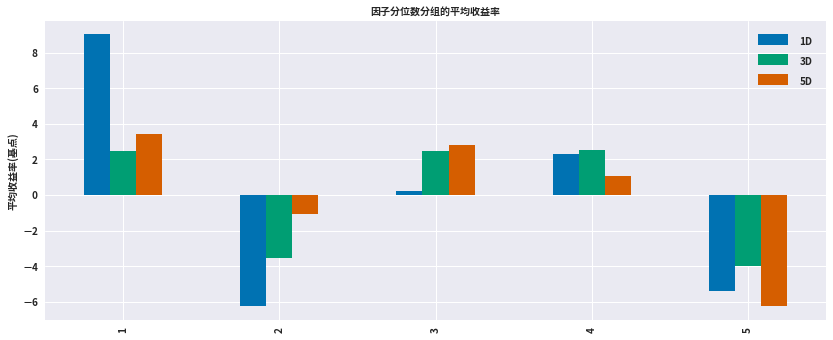

In [10]:
alphalens.tears.create_summary_tear_sheet(factor_data)

# 准备数据运行`Pyfolio`

我们可以在Alphalens分析中看到，分位数1和5是最具有预测性的，因此我们将仅使用这些分位数来构建投资组合数据。

In [11]:
pf_returns, pf_positions, pf_benchmark = \
    alphalens.performance.create_pyfolio_input(factor_data,
                                               period='1D',
                                               capital=100000,
                                               long_short=True,
                                               group_neutral=False,
                                               equal_weight=True,
                                               quantiles=[1,5],
                                               groups=None,
                                               benchmark_period='1D')

In [12]:
pf_benchmark.index.tz

<UTC>

现在我们已经准备好了数据，我们可以运行`Pyfolio`函数

开始日期,2017-12-23
结束日期,2018-05-11
累计月数,6
,回测
年化收益率,-12.0%
累计收益率,-6.9%
年度波动性,10.5%
夏普比率,-1.16
回收比率,-1.16
稳定度,0.53
最大回撤,-10.3%


最大回撤,净回撤百分比,波峰日期,波谷日期,回本日期,回本天数
0,10.33,2018-01-03,2018-02-06,NaT,NaN
1,0.58,2017-12-24,2017-12-25,2017-12-26,2
2,0.52,2018-01-01,2018-01-02,2018-01-03,3
3,0.16,2017-12-27,2017-12-28,2017-12-29,3
4,0.00,2017-12-23,2017-12-23,2017-12-23,0


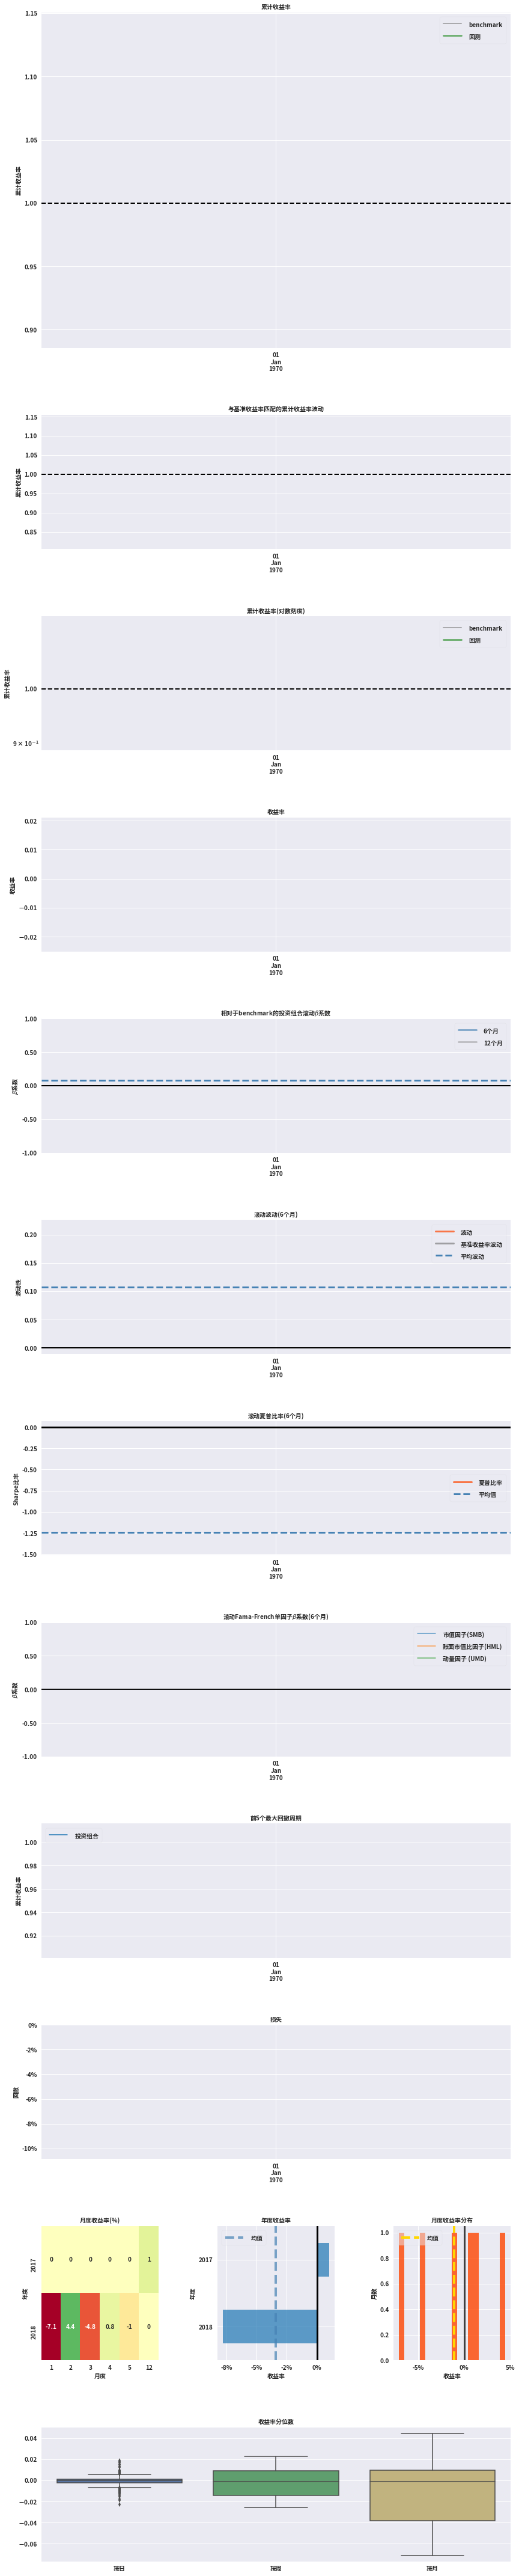

/home/ldf/pkg_source/czipline/src/pyfolio/pyfolio/tears.py:951: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


前十位多头头寸,max
asset,
000538,0.54%
000661,0.54%
000725,0.54%
000735,0.54%
000790,0.54%
000831,0.54%
000860,0.54%
000886,0.54%
000938,0.54%


前十位空头头寸,max
asset,
000066,-0.59%
000488,-0.59%
000507,-0.59%
000528,-0.59%
000613,-0.59%
000651,-0.59%
000672,-0.59%
000818,-0.59%
000830,-0.59%


前十位总头寸,max
asset,
000066,0.59%
000488,0.59%
000507,0.59%
000528,0.59%
000613,0.59%
000651,0.59%
000672,0.59%
000818,0.59%
000830,0.59%


历史总头寸,max
asset,
600104,0.59%
002466,0.59%
002373,0.59%
601009,0.59%
600362,0.59%
601088,0.59%
002271,0.59%
002268,0.59%
601111,0.59%


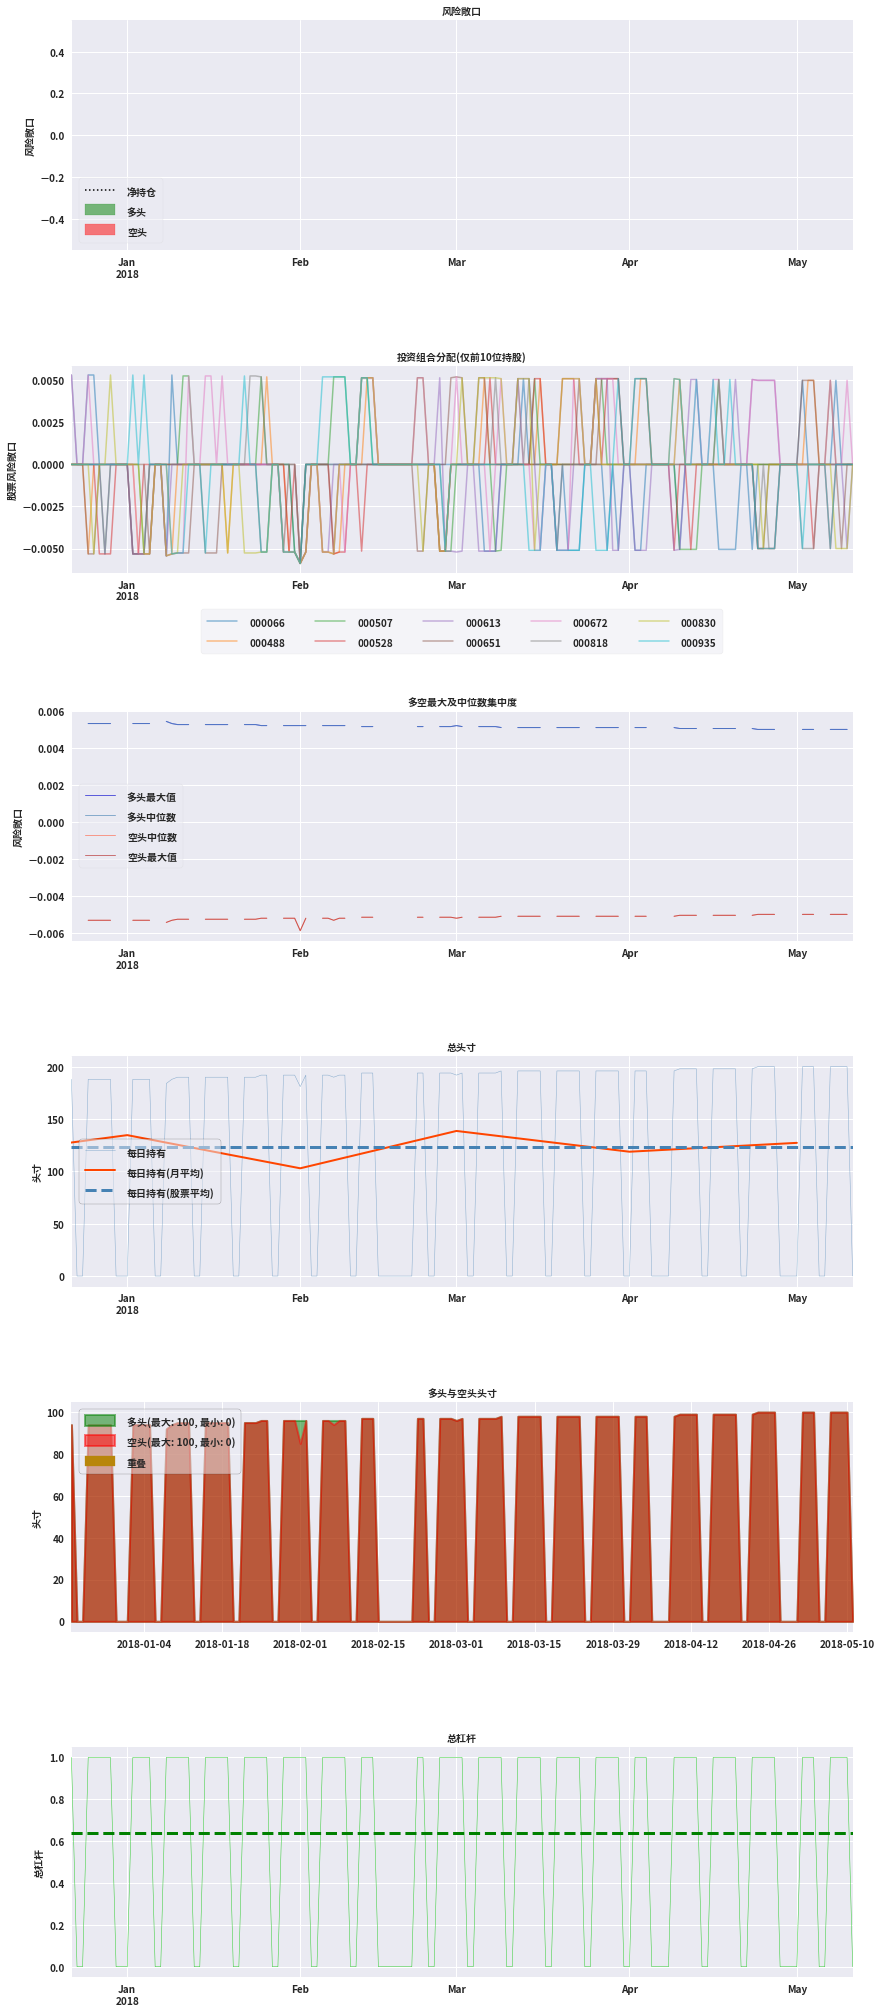

In [13]:
pyfolio.tears.create_full_tear_sheet(pf_returns,
                                     positions=pf_positions,
                                     benchmark_rets=pf_benchmark)

## 分析数据的子集

有时，分析因子数据的子集可能很有用，例如，在一周的不同日子里查看您的因子的比较可能很有趣。 下面我们将看到如何选择和分析与星期一相对应的因子数据，仓位将持续5天。

In [14]:
monday_factor_data = factor_data[factor_data.index.get_level_values('date')
                                 .weekday == 0]

In [15]:
pf_returns, pf_positions, pf_benchmark = \
    alphalens.performance.create_pyfolio_input(monday_factor_data,
                                               period='5D',
                                               capital=100000,
                                               long_short=True,
                                               group_neutral=False,
                                               equal_weight=True,
                                               quantiles=[1,5],
                                               groups=None,
                                               benchmark_period='1D')

开始日期,2017-12-26
结束日期,2018-05-14
累计月数,6
,回测
年化收益率,12.8%
累计收益率,6.9%
年度波动性,9.0%
夏普比率,1.38
回收比率,3.20
稳定度,0.73
最大回撤,-4.0%


最大回撤,净回撤百分比,波峰日期,波谷日期,回本日期,回本天数
0,3.99,2018-01-14,2018-02-05,2018-02-26,31
1,2.44,2018-03-11,2018-03-19,2018-04-02,16
2,0.48,2018-05-13,2018-05-14,NaT,NaN
3,0.00,2017-12-26,2017-12-26,2017-12-26,1
4,0.00,2017-12-26,2017-12-26,2017-12-26,1


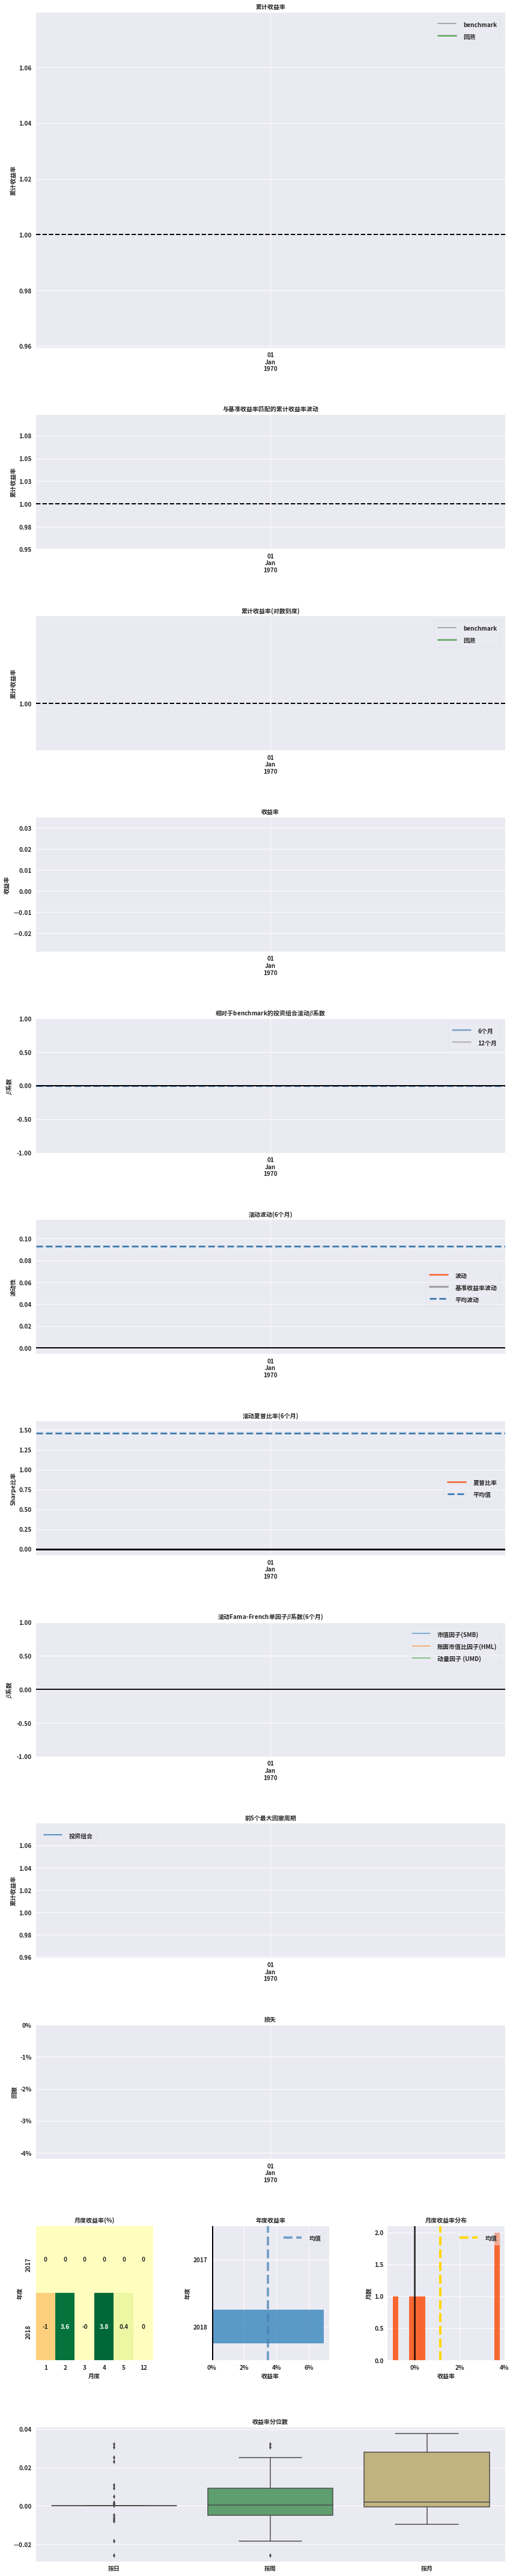

/home/ldf/pkg_source/czipline/src/pyfolio/pyfolio/tears.py:951: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


前十位多头头寸,max
asset,
000538,0.56%
000703,0.56%
000725,0.56%
000935,0.56%
002027,0.56%
002110,0.56%
002202,0.56%
002236,0.56%
002264,0.56%


前十位空头头寸,max
asset,
000613,-0.56%
000670,-0.56%
000938,-0.56%
002016,-0.56%
002038,-0.56%
002129,-0.56%
002137,-0.56%
002151,-0.56%
002229,-0.56%


前十位总头寸,max
asset,
000538,0.56%
000613,0.56%
000670,0.56%
000703,0.56%
000725,0.56%
000935,0.56%
000938,0.56%
002016,0.56%
002027,0.56%


历史总头寸,max
asset,
300684,0.56%
300666,0.56%
300514,0.56%
600555,0.56%
002016,0.56%
300104,0.56%
300604,0.56%
300613,0.56%
300101,0.56%


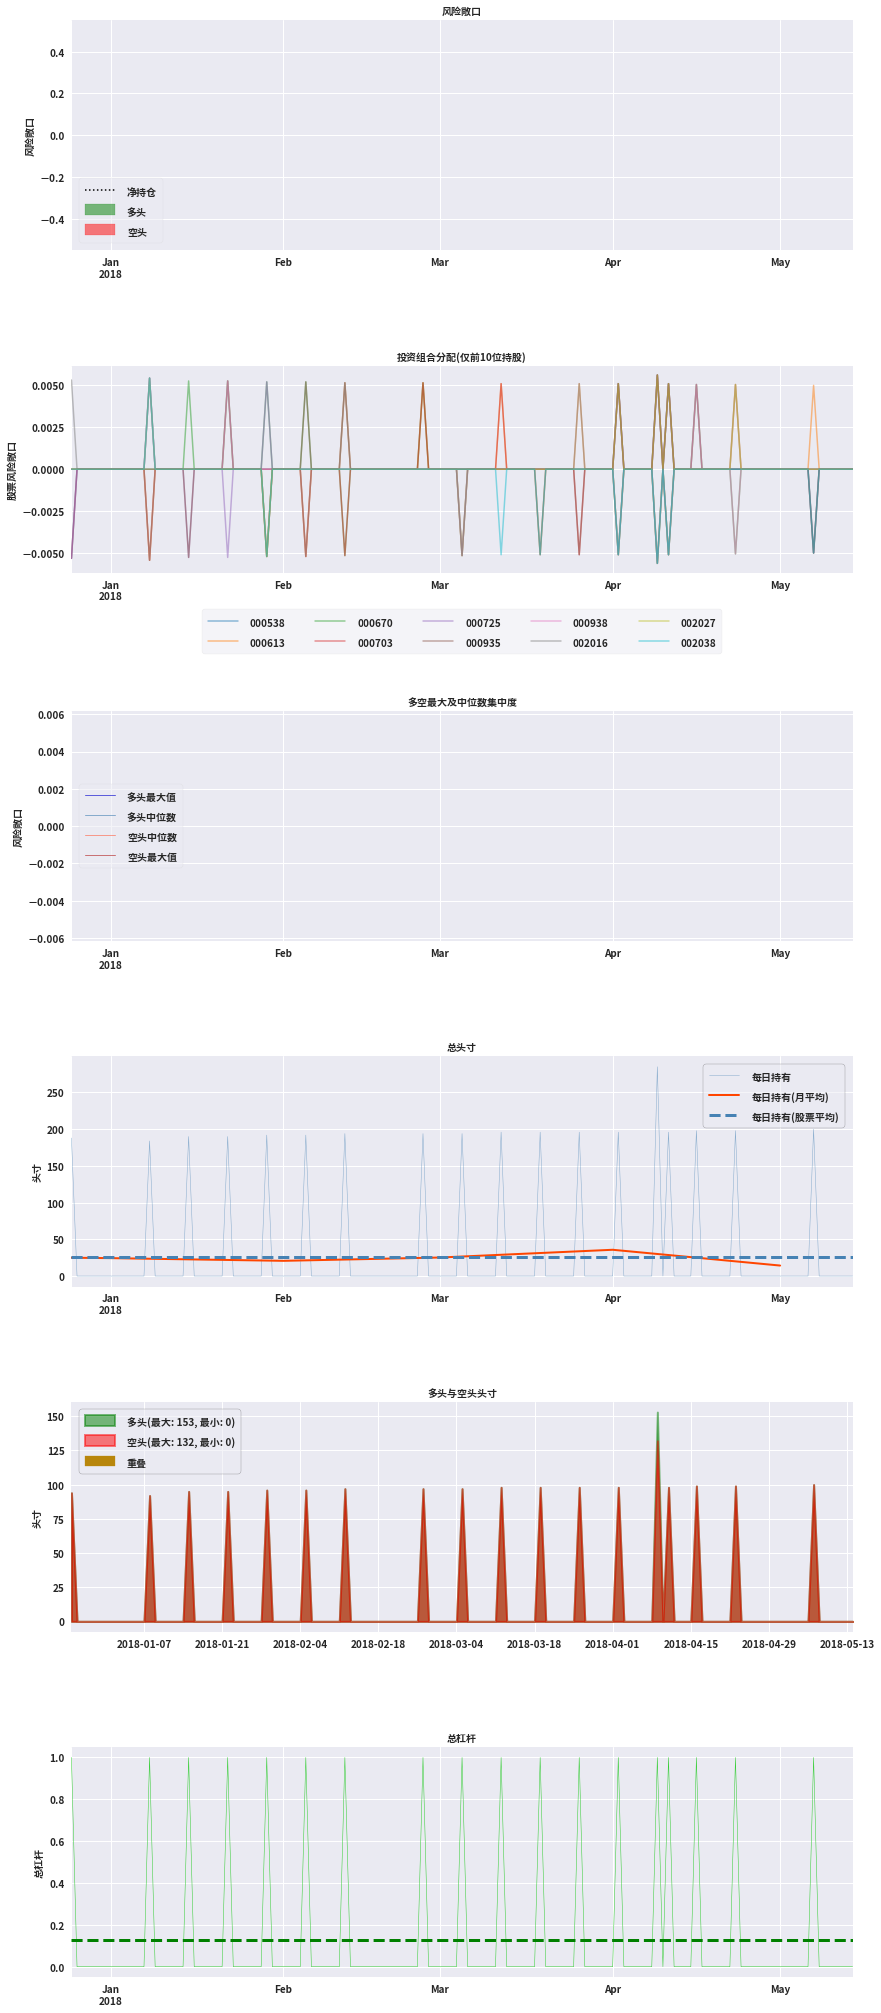

In [16]:
pyfolio.tears.create_full_tear_sheet(pf_returns,
                                     positions=pf_positions,
                                     benchmark_rets=pf_benchmark)